In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
def random_hot(batch_size):
    tensor = torch.zeros(batch_size, 10, device=device)
    random_index = [random.randint(0, 9) for _ in range(batch_size)]
    for t, index in enumerate(random_index):
        tensor[t][index] = 1
    return tensor

def to_hot(labels):
    tensor = torch.zeros(labels.size(0), 10, device=device)
    for t, index in enumerate(labels):
        tensor[t][index] = 1
    return tensor

In [3]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 10, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 4),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
        )
        self.linear = nn.Sequential(
            nn.Linear(500 + 10, 100),
            nn.LeakyReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []
        self.loss_func = nn.BCELoss()

    def forward(self, inputs, label_tensors):
        inputs = torch.cat((self.conv(inputs).view(-1, 500), label_tensors), 1)
        return self.linear(inputs)

    def nn_train(self, inputs, label_tensors, targets):
        outputs = self(inputs, label_tensors)
        loss = self.loss_func(outputs, targets)
        self.counter += 1
        if not self.counter % 10:
            self.progress.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(figsize=(16, 8), alpha=0.1, marker='.', grid=True)

In [4]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(110, 3 * 11 * 11),
            nn.LeakyReLU()
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(3, 64, 4),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, 2, 2),
            nn.Tanh()
        )
        # self.model = nn.Sequential(
        #     nn.ConvTranspose2d(110, 128, 5),
        #     nn.BatchNorm2d(128),
        #     nn.LeakyReLU(),
        #     nn.ConvTranspose2d(128, 64, 4, 2),
        #     nn.BatchNorm2d(64),
        #     nn.LeakyReLU(),
        #     nn.ConvTranspose2d(64, 16, 3),
        #     nn.BatchNorm2d(16),
        #     nn.LeakyReLU(),
        #     nn.ConvTranspose2d(16, 1, 2, 2),
        #     nn.Tanh()
        # )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []

    def forward(self, inputs, label_tensors):
        return self.conv(self.linear(torch.cat((inputs, label_tensors), 1)).view(-1, 3, 11, 11))

    def nn_train(self, discriminator: D, inputs, label_tensors, targets):
        g_outputs = self(inputs, label_tensors)
        d_outputs = discriminator(g_outputs, label_tensors)
        loss = discriminator.loss_func(d_outputs, targets)
        self.counter += 1
        if not self.counter % 10:
            self.progress.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(figsize=(16, 8), alpha=0.1, marker='.', grid=True)

    def plot_images(self, label_tensor):
        _, canvases = plt.subplots(1, 4)
        for i in range(4):
            canvases[i].imshow(self(torch.randn(1, 100, device=device), to_hot(torch.tensor([label_tensor]))).cpu().detach().numpy().reshape(28, 28), interpolation='none', cmap='Blues')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

In [6]:
PATH_D = '../pth/GAN_mnistD.pth'
PATH_G = '../pth/GAN_mnistG.pth'
epoch = 1

In [7]:
d = D().to(device)
g = G().to(device)

In [8]:
# try:
#     d = torch.load(PATH_D, map_location=device)
#     g = torch.load(PATH_G, map_location=device)
# except FileNotFoundError:
#     d = D().to(device)
#     g = G().to(device)

In [12]:
%%time
for e in range(epoch):
    print(f'epcoh-{e + 1}...', end='')
    for step, (data, label) in enumerate(trainloader):
        data = data.to(device)
        size = data.size(0)
        d.nn_train(data * -1, to_hot(label), torch.ones(size, 1, device=device))
        random_label = random_hot(size)
        d.nn_train(g(torch.randn(size, 100, device=device), random_label), random_label, torch.zeros(size, 1, device=device))
        random_label = random_hot(size)
        g.nn_train(d, torch.randn(size, 100, device=device), random_label, torch.ones(size, 1, device=device))
    print('finished')

epcoh-1...finished
CPU times: total: 6min 19s
Wall time: 3min 18s


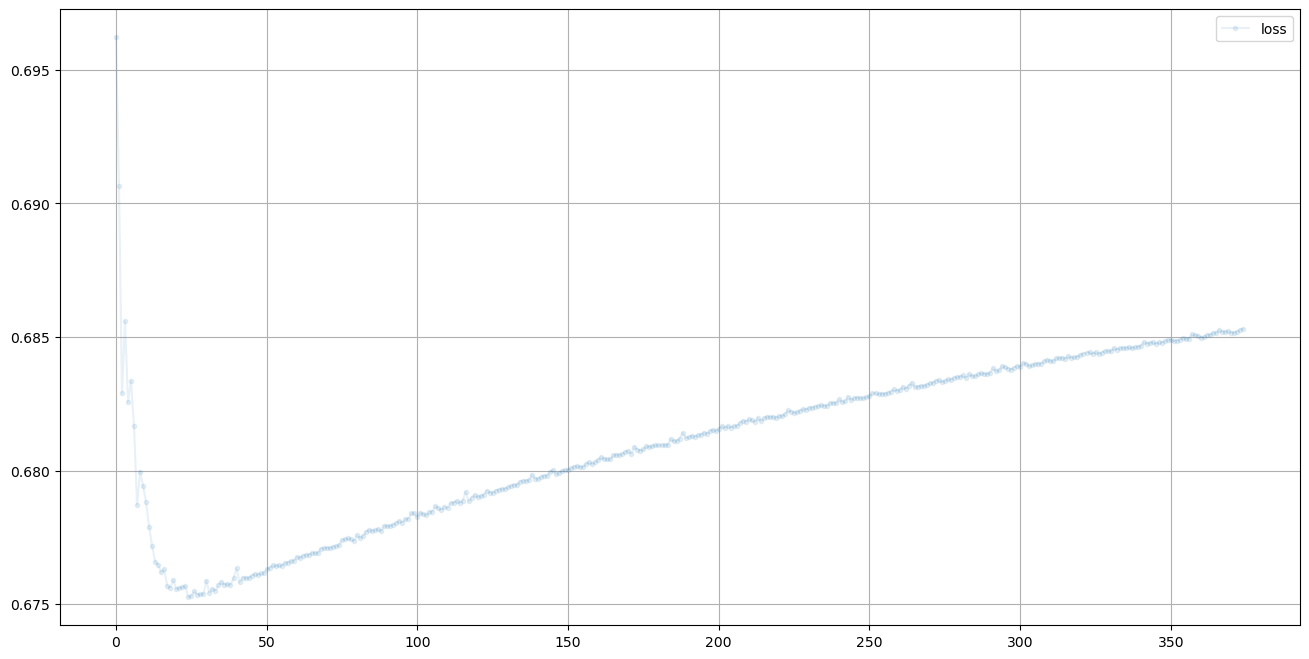

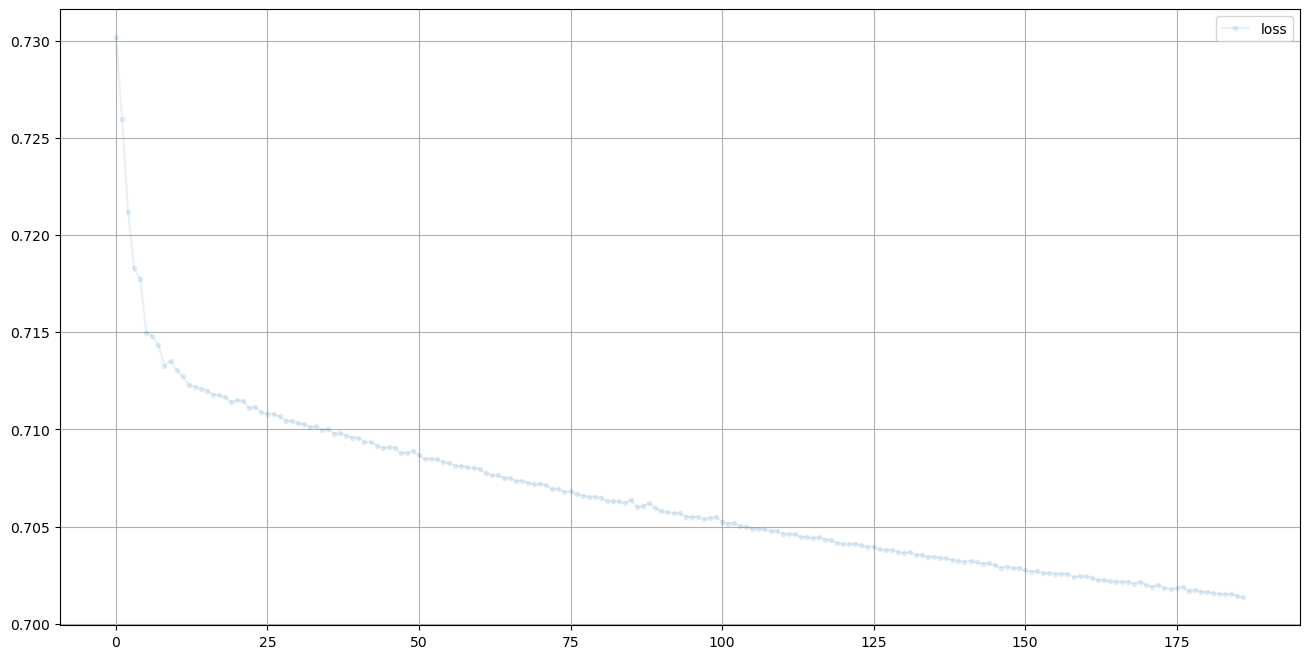

In [13]:
d.plot_progress()
g.plot_progress()

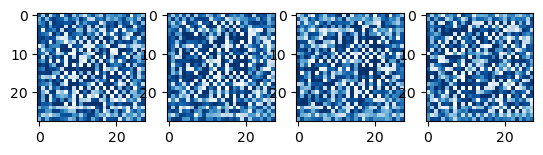

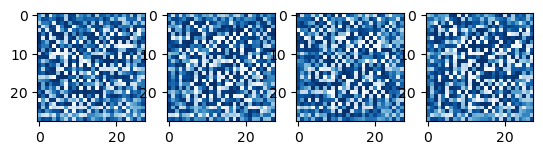

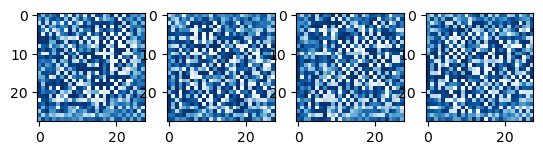

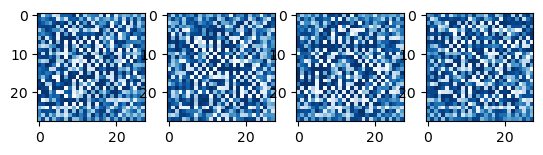

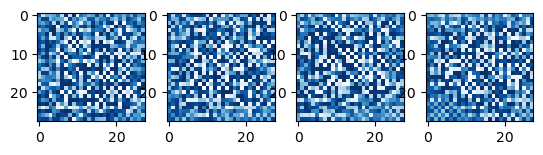

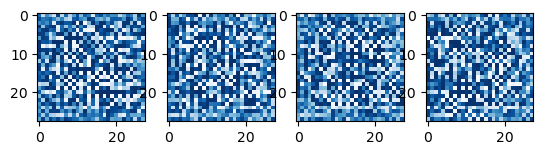

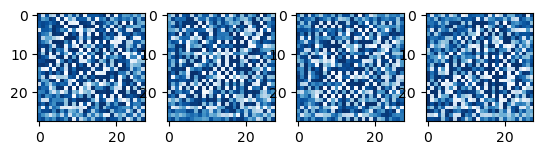

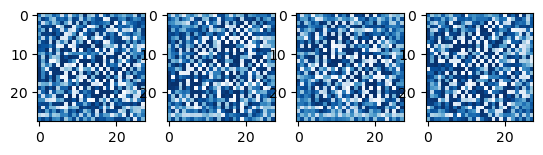

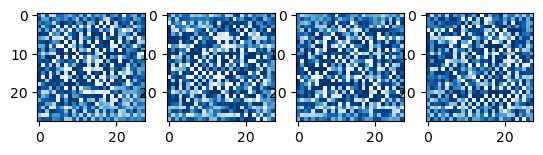

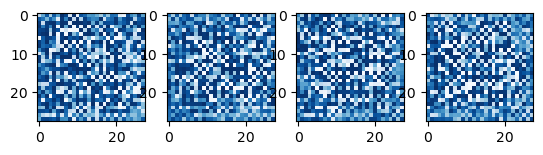

In [14]:
for n in range(10):
    g.plot_images(n)